In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/dataset/kindle_review.csv')

In [ ]:
import pandas as pd
import numpy as np
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

!pip install contractions
import contractions




In [ ]:
data.head()

,Unnamed: 0,rating,reviewText,summary
0,0,5,This book was the very first bookmobile book I...,50 + years ago...
1,1,1,"When I read the description for this book, I c...",Boring! Boring! Boring!
2,2,5,I just had to edit this review. This book is a...,Wiggleliscious/new toy ready/!!
3,3,5,I don't normally buy 'mystery' novels because ...,Very good read.
4,4,5,"This isn't the kind of book I normally read, a...",Great Story!


In [ ]:
data.tail()

,Unnamed: 0,rating,reviewText,summary
11995,11995,2,Had to read certain passages twice--typos. Wi...,Where's the meat?
11996,11996,3,Not what i expected. yet a very interesting bo...,Interesting
11997,11997,5,Dragon Knights is a world where Knights ride d...,"Dragon Knights, Wings of Change (I Dream of Dr..."
11998,11998,4,"Since this story is very short, it's hard to s...","Good writing, short story"
11999,11999,4,from 1922 an amazing collection of info on sym...,interesting public domain book


In [ ]:
data.isnull().any()

Unnamed: 0    False
rating        False
reviewText    False
summary        True
dtype: bool

In [ ]:
data.drop(columns=['summary'], inplace=True)
data.drop(columns=['Unnamed: 0'], inplace=True)



In [ ]:
data.isnull().any()

rating        False
reviewText    False
dtype: bool

In [ ]:
data['rating'].value_counts()

rating
5    3000
4    3000
1    2000
3    2000
2    2000
Name: count, dtype: int64

In [ ]:
data['Sentiment'] = data['rating'].apply(lambda x: 'negative' if x in [1, 2] else ('neutral' if x == 3 else 'positive'))


In [ ]:
data.head()

,rating,reviewText,Sentiment
0,5,This book was the very first bookmobile book I...,positive
1,1,"When I read the description for this book, I c...",negative
2,5,I just had to edit this review. This book is a...,positive
3,5,I don't normally buy 'mystery' novels because ...,positive
4,5,"This isn't the kind of book I normally read, a...",positive


In [ ]:
def clean_data(text):
  text = re.sub(r'\d+', '' , text)
  text = re.sub(r"(?i)\b(\w+)\s+n't\b", r"\1n't", text)
  text = contractions.fix(text)
  text = re.sub(r'[^\w\s]', '', text)
  text = text.lower()
  return text

data['Cleaned_review'] = data["reviewText"].apply(clean_data)

In [ ]:
data.head()

,rating,reviewText,Sentiment,Cleaned_review
0,5,This book was the very first bookmobile book I...,positive,this book was the very first bookmobile book i...
1,1,"When I read the description for this book, I c...",negative,when i read the description for this book i co...
2,5,I just had to edit this review. This book is a...,positive,i just had to edit this review this book is an...
3,5,I don't normally buy 'mystery' novels because ...,positive,i do not normally buy mystery novels because i...
4,5,"This isn't the kind of book I normally read, a...",positive,this is not the kind of book i normally read a...


In [ ]:
tokens = Tokenizer()
tokens.fit_on_texts(data['Cleaned_review'])
sequences = tokens.texts_to_sequences(data['Cleaned_review'])
word_index = tokens.word_index

max_sequence_length = 256

x = pad_sequences(sequences, maxlen = max_sequence_length)

y = pd.get_dummies(data['Sentiment']).values

In [ ]:
data['Sentiment'].unique()

array(['positive', 'negative', 'neutral'], dtype=object)

In [ ]:
data.head()

,rating,reviewText,Sentiment,Cleaned_review
0,5,This book was the very first bookmobile book I...,positive,this book was the very first bookmobile book i...
1,1,"When I read the description for this book, I c...",negative,when i read the description for this book i co...
2,5,I just had to edit this review. This book is a...,positive,i just had to edit this review this book is an...
3,5,I don't normally buy 'mystery' novels because ...,positive,i do not normally buy mystery novels because i...
4,5,"This isn't the kind of book I normally read, a...",positive,this is not the kind of book i normally read a...


In [ ]:
data.isnull().any()

rating            False
reviewText        False
Sentiment         False
Cleaned_review    False
dtype: bool

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 42)

Model - 1

In [ ]:
embedding_dim = 32
rate = 0.01
dropout_rate = 0.3

model = Sequential([
    Embedding(len(word_index) +1, embedding_dim, input_length = max_sequence_length), LSTM(64, return_sequences=False),
    Dropout(dropout_rate),
    Dense(3, activation = 'softmax', kernel_regularizer = regularizers.l1(rate) )
])

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 256, 32)           1429504   
                                                                 
 lstm_1 (LSTM)               (None, 64)                24832     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 1454531 (5.55 MB)
Trainable params: 1454531 (5.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
history = model.fit(x_train, y_train, validation_split=0.1, epochs=20, batch_size=64, callbacks=[es])

Epoch 1/20
135/135 [==============================] - 32s 216ms/step - loss: 1.1070 - accuracy: 0.5818 - val_loss: 0.9086 - val_accuracy: 0.6677
Epoch 2/20
135/135 [==============================] - 28s 205ms/step - loss: 0.7455 - accuracy: 0.7484 - val_loss: 0.7861 - val_accuracy: 0.7167
Epoch 3/20
135/135 [==============================] - 27s 197ms/step - loss: 0.6060 - accuracy: 0.7914 - val_loss: 0.7908 - val_accuracy: 0.7156
Epoch 4/20
135/135 [==============================] - 31s 232ms/step - loss: 0.5269 - accuracy: 0.8111 - val_loss: 0.8005 - val_accuracy: 0.7156
Epoch 5/20
135/135 [==============================] - 29s 214ms/step - loss: 0.4603 - accuracy: 0.8309 - val_loss: 0.8535 - val_accuracy: 0.7177
Epoch 5: early stopping


Model - Evaluation

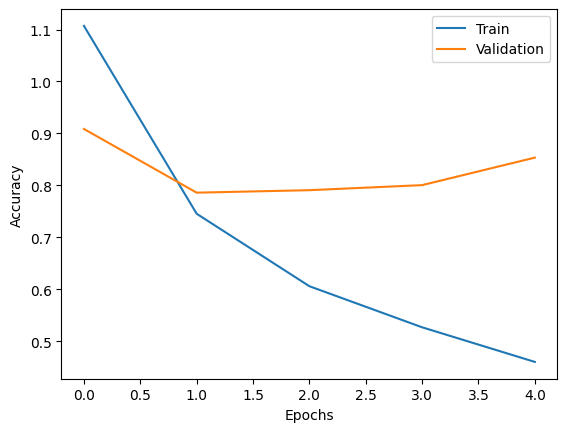

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label = 'Train')
plt.plot(history.history['val_loss'], label = 'Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Accuracy Calculation

In [ ]:
from sklearn.metrics import confusion_matrix, class_likelihood_ratios

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print("Accuracy:", accuracy_score(y_test_classes, y_pred_classes))

75/75 [==============================] - 4s 43ms/step
Accuracy: 0.72


Confusion Matrix

In [ ]:
print("Confusion Matrix:\n", confusion_matrix(y_test_classes, y_pred_classes))

Confusion Matrix:
 [[ 680   18  101]
 [ 187   22  203]
 [ 140   23 1026]]


Classification Report

In [ ]:
print("Classification Report:\n", classification_report(y_test_classes, y_pred_classes))

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.85      0.75       799
           1       0.35      0.05      0.09       412
           2       0.77      0.86      0.81      1189

    accuracy                           0.72      2400
   macro avg       0.60      0.59      0.55      2400
weighted avg       0.67      0.72      0.67      2400



In [ ]:
def predict_sentiment(texts, model, tokenizer, max_sequence_length):
  texts_clean = [clean_data(text) for text in texts]

  sequences = tokenizer.texts_to_sequences(texts_clean)

  sequences_padded = pad_sequences(sequences, maxlen= max_sequence_length)

  predictions = model.predict(sequences_padded)
  sentiments = np.argmax(predictions, axis=1)

  sentiment_labels = []
  for sentiment in sentiments:
    if sentiment == 0:
        sentiment_labels.append("Negative")
    elif sentiment == 1:
        sentiment_labels.append("Neutral")
    else:
        sentiment_labels.append("Positive")

  return sentiment_labels

In [ ]:
texts = ["i loved the story ", "overpriced book i did not like it", "good story but bad ending"]
sentiment_labels = predict_sentiment(texts, model, tokens, max_sequence_length)
print(sentiment_labels)

1/1 [==============================] - 0s 473ms/step
['Positive', 'Negative', 'Neutral']
